Please check this [article](https://medium.com/analytics-vidhya/an-introduction-to-multi-label-text-classification-b1bcb7c7364c?sk=8a30075009552cfd4a7534663edaed7e) for detailed explanation.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cleaned-text-1/cleaned_text.csv
/kaggle/input/topic-modeling-for-research-articles/train.csv
/kaggle/input/topic-modeling-for-research-articles/test.csv
/kaggle/input/cleaned-text/cleaned_text.csv
/kaggle/input/n-corpus/n_corpus.csv
/kaggle/input/text-cleaned/cleaned_text_1.csv
/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin.gz
/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Reading Data Files**

In [3]:
train_df=pd.read_csv("../input/topic-modeling-for-research-articles/train.csv")
test_df=pd.read_csv("../input/topic-modeling-for-research-articles/test.csv")

In [4]:



train_df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [5]:
train_df.shape

(20972, 9)

In [6]:
x=train_df.iloc[:,3:].sum()
rowsums=train_df.iloc[:,2:].sum(axis=1)
no_label_count = 0
for sum in rowsums.items():
    if sum==0:
        no_label_count +=1

print("Total number of articles = ",len(train_df))
print("Total number of articles without label = ",no_label_count)
print("Total labels = ",x.sum())

Total number of articles =  20972
Total number of articles without label =  0
Total labels =  26267


In [7]:
print("Check for missing values in Train dataset")
print(train_df.isnull().sum().sum())
print("Check for missing values in Test dataset")
null_check=test_df.isnull().sum()
print(null_check)

Check for missing values in Train dataset
0
Check for missing values in Test dataset
ID          0
TITLE       0
ABSTRACT    0
dtype: int64


Lets now check the data types of columns, to assure that each column have the same data type as it should be (sometimes in some datasets there are some columns which has float on integer values but the data type of those columns is object, so for that case we need to change the datatype.

In [8]:
train_df.dtypes

ID                       int64
TITLE                   object
ABSTRACT                object
Computer Science         int64
Physics                  int64
Mathematics              int64
Statistics               int64
Quantitative Biology     int64
Quantitative Finance     int64
dtype: object


Now lets check each how many abstracts belongs to each category

In [9]:
categories=["Computer Science","Physics","Mathematics","Statistics","Quantitative Biology","Quantitative Finance"]
category_count=[]
for i in categories:
  category_count.append(train_df[i].sum())

In [10]:
category_count

[8594, 6013, 5618, 5206, 587, 249]

<BarContainer object of 6 artists>

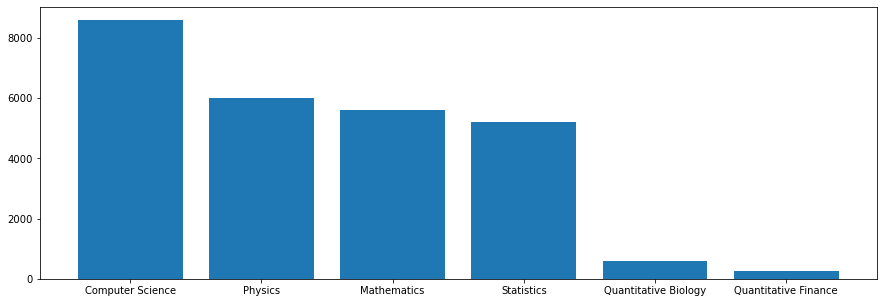

In [11]:
plt.figure(figsize=(15,5))
plt.bar(categories,category_count)



From the above plot its clear that "Quantitative biolgy" and "quantitative Finance" have too much less values, that means the dataset is imbalanced.

As the dataset is imbalanced, to make it balanced we can apply resampling techniques, the dataset is small so we can try oversampling of these two classes. 

we will implement oversampling later, first we will try to build a basic classification model.

now lets plot a figure for word count for each category.

In [12]:
total_word_count_in_each_category=[]
for i in categories:
  abstracts = train_df.where(train_df[i]==1)[['ABSTRACT']]
  count=pd.Series(abstracts.values.flatten()).str.len().sum()
  total_word_count_in_each_category.append(count)

<BarContainer object of 6 artists>

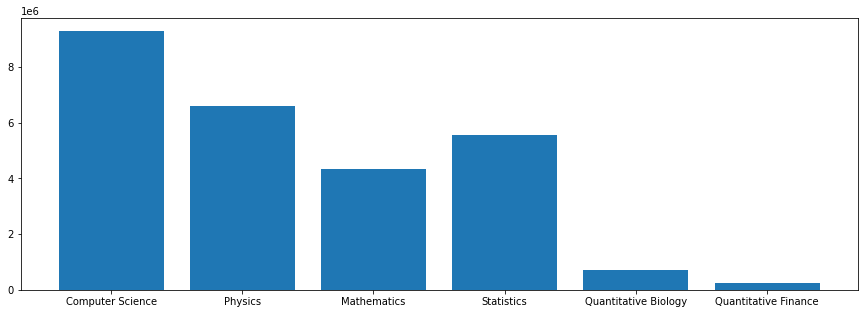

In [13]:
plt.figure(figsize=(15,5))
plt.bar(categories,total_word_count_in_each_category)

Word count also almost in the same proportion as the number of texts in each category, only difference is statistics has more word than mathematics even the number of articles are more for mathematics.

now lets analyze avg word length of abstract, for each category.

In [14]:
avg_abstract_len_for_each_category=[]
for i in range(6):
  avg_abstract_len_for_each_category.append(total_word_count_in_each_category[i]/category_count[i])

<BarContainer object of 6 artists>

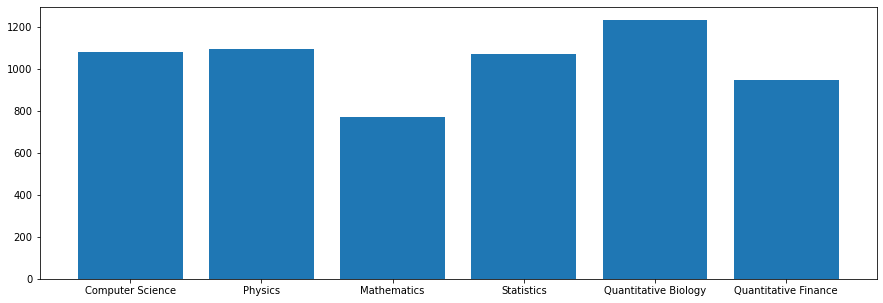

In [15]:
plt.figure(figsize=(15,5))
plt.bar(categories,avg_abstract_len_for_each_category)

From the above plot its clear that articles of quantitaive biology are longest, and mathematics articles are shortest.

lets concatenate Title and Abstract, and make it one big text.

In [16]:
train_df["text"]=train_df["TITLE"]+" "+train_df["ABSTRACT"]

dropping the TITLE and ABSTRACT columns.

In [17]:
train_df.drop(["TITLE","ABSTRACT"],axis=1,inplace=True)

In [18]:
train_df.head()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,text
0,1,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps ...
1,2,1,0,0,0,0,0,Rotation Invariance Neural Network Rotation ...
2,3,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...
3,4,0,0,1,0,0,0,A finite element approximation for the stochas...
4,5,1,0,0,1,0,0,Comparative study of Discrete Wavelet Transfor...


Lets make a function for train test split that we will need further.

In [19]:
from sklearn.model_selection import train_test_split


In [20]:
def split(X,y,test_size):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=test_size,random_state=42)
    return (X_train,X_test,y_train,y_test)

In [21]:
import nltk
import re 
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


# **Cleaning the text**

In [22]:
lemmatizer=WordNetLemmatizer()
ps=PorterStemmer()

In [23]:
corpus=" ".join(train_df.text)

In [24]:
'''n_corpus=[]
for i in range(train_df.shape[0]):
  title=re.sub("[^a-zA-Z]"," ",train_df.text[i])
  title=title.lower()
  title=title.split()
  title=[lemmatizer.lemmatize(word) for word in title if not word in stopwords.words("english")]
  title=" ".join(title)
  n_corpus.append(title)
lemmatizer.lemmatize("studies")'''

'n_corpus=[]\nfor i in range(train_df.shape[0]):\n  title=re.sub("[^a-zA-Z]"," ",train_df.text[i])\n  title=title.lower()\n  title=title.split()\n  title=[lemmatizer.lemmatize(word) for word in title if not word in stopwords.words("english")]\n  title=" ".join(title)\n  n_corpus.append(title)\nlemmatizer.lemmatize("studies")'

In [25]:
# Saving this n_corpus to a csv file so that we don't have run above cell every time because it is taking too much time
#import pandas as pd
# Create a local file to upload.
#df_ = pd.DataFrame(n_corpus)
#df_.to_csv("n_corpus.csv")

In [26]:
# n_corpus1=pd.read_csv('../input/n-corpus/n_corpus.csv')
# n_corpus=list(n_corpus1['0'].values)
# n_corpus[:2]


importing spacy library for lemmatizing the words and using regular expression we will clean the text(removing numeric characters and stopwards )

In [27]:
import spacy

In [28]:
nlp=spacy.load("en_core_web_sm")




we will store the cleaned text into a list

In [29]:
# cleaned_text=[]
# for i in range(train_df.shape[0]):
#     text=train_df.text[i]
#     text==text.lower().strip()
#     text=re.sub("[^a-zA-Z]"," ",text)
#     text=nlp(text)
#     text=[token.lemma_.strip() for token in text if (not token.is_stop) and (len(token)>1)]
#     text=" ".join(text)
#     cleaned_text.append(text)
    
    
      

In [30]:
# cleaned_text[:1]

In [31]:
# Saving this cleaned text to a csv file so that we don't have run above cell every time because it is time taking
# import pandas as pd
# # Create a local file to upload.
# df = pd.DataFrame(cleaned_text)
# df.to_csv("cleaned_text_1.csv")

In [32]:
cleaned_text=pd.read_csv('../input/text-cleaned/cleaned_text_1.csv')
cleaned_text=list(cleaned_text['0'].values)
cleaned_text[:3]

['reconstruct subject Specific effect map  predictive model allow subject specific inference analyze disease relate alteration neuroimage datum give subject data inference level global identifiye condition presence subject local detect condition effect individual measurement extract subject datum global inference widely local inference form subject specific effect map rarely exist model yield noisy detection compose disperse isolate island article propose reconstruction method name RSM improve subject specific detection predictive modeling approach particular binary classifier RSM specifically aim reduce noise sampling error associate finite sample example train classifier propose method wrapper type algorithm different binary classifier diagnostic manner information condition presence Reconstruction pose Maximum Posteriori problem prior model parameter estimate train datum classifier specific fashion experimental evaluation perform synthetically generate datum datum Alzheimer Disease 

In [33]:
# Converting all texts to lowercase
for i in range(len(cleaned_text)):
    cleaned_text[i]=cleaned_text[i].lower()
    
cleaned_text[:1]

['reconstruct subject specific effect map  predictive model allow subject specific inference analyze disease relate alteration neuroimage datum give subject data inference level global identifiye condition presence subject local detect condition effect individual measurement extract subject datum global inference widely local inference form subject specific effect map rarely exist model yield noisy detection compose disperse isolate island article propose reconstruction method name rsm improve subject specific detection predictive modeling approach particular binary classifier rsm specifically aim reduce noise sampling error associate finite sample example train classifier propose method wrapper type algorithm different binary classifier diagnostic manner information condition presence reconstruction pose maximum posteriori problem prior model parameter estimate train datum classifier specific fashion experimental evaluation perform synthetically generate datum datum alzheimer disease 

To create the vocabulary, we will join all the texts.

In [34]:
vocabulary=" ".join(cleaned_text)
x=set(vocabulary.split())
len(x)

45593

In [35]:
train_df.head()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,text
0,1,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps ...
1,2,1,0,0,0,0,0,Rotation Invariance Neural Network Rotation ...
2,3,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...
3,4,0,0,1,0,0,0,A finite element approximation for the stochas...
4,5,1,0,0,1,0,0,Comparative study of Discrete Wavelet Transfor...


There are total 45593 unique words in all the articles and only those we will use into our model.

In [36]:
train_df['cleaned_text']=cleaned_text
train_df.head()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,text,cleaned_text
0,1,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps ...,reconstruct subject specific effect map predi...
1,2,1,0,0,0,0,0,Rotation Invariance Neural Network Rotation ...,rotation invariance neural network rotation i...
2,3,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...,spherical polyharmonic poisson kernel polyharm...
3,4,0,0,1,0,0,0,A finite element approximation for the stochas...,finite element approximation stochastic maxwel...
4,5,1,0,0,1,0,0,Comparative study of Discrete Wavelet Transfor...,comparative study discrete wavelet transforms ...


In [37]:
train_df.cleaned_text[0]

'reconstruct subject specific effect map  predictive model allow subject specific inference analyze disease relate alteration neuroimage datum give subject data inference level global identifiye condition presence subject local detect condition effect individual measurement extract subject datum global inference widely local inference form subject specific effect map rarely exist model yield noisy detection compose disperse isolate island article propose reconstruction method name rsm improve subject specific detection predictive modeling approach particular binary classifier rsm specifically aim reduce noise sampling error associate finite sample example train classifier propose method wrapper type algorithm different binary classifier diagnostic manner information condition presence reconstruction pose maximum posteriori problem prior model parameter estimate train datum classifier specific fashion experimental evaluation perform synthetically generate datum datum alzheimer disease n

In [38]:
X_train,X_test,y_train,y_test=split(train_df.loc[:,"cleaned_text"],train_df.loc[:,categories],0.2)

In [39]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((16777,), (4195,), (16777, 6), (4195, 6))

Now our text is cleaned, we will apply Tfidf on text data to change into a matrix of numericals.

# **Changing text into numericals using Tfidf technique**

In [40]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [41]:
tfv=TfidfVectorizer(min_df=3,max_features=30000,strip_accents="unicode",analyzer="word",token_pattern=r"\w{1,}",ngram_range=(1,3),use_idf=1,smooth_idf=1,sublinear_tf=1,stop_words="english")

In [42]:
tfv.fit(list(X_train)+list(X_test))
xtrain_tfv=tfv.transform(X_train)
xtest=tfv.transform(X_test)

In [43]:
xtrain_tfv.shape

(16777, 30000)

Target columns has 6 columns , so lets change into one columns which will have all 6 different categories.

In [44]:
y_train_new=y_train.idxmax(axis=1)
y_test_new=y_test.idxmax(axis=1)

In [45]:
y_train_new.nunique(), y_test_new.nunique()

(6, 6)

**Lest apply a simple LogisticRegression model to classify.**

In [46]:
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(C=1.0,solver="sag")
clf.fit(xtrain_tfv,y_train_new)

LogisticRegression(solver='sag')

Apply grid search to optimize the hyperparameters.

In [47]:
# from sklearn.model_selection import GridSearchCV
# params={
#     'C':[0.1,0.3,0.5,0.8,1],
#     'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#     'penalty':['l1', 'l2', 'elasticnet', 'none']
# }
# gs_knn = GridSearchCV(LogisticRegression(),
#                       param_grid=params,
#                       scoring='accuracy',
#                       cv=5)

# gs_model = gs_knn.fit(X_train_vect_avg, y_train.values.ravel())

In [48]:
#gs_model.best_params_

In [49]:
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(C=0.3,solver="sag")
clf.fit(xtrain_tfv,y_train_new)

LogisticRegression(C=0.3, solver='sag')

In [50]:
train_preds=clf.predict(xtrain_tfv)
test_preds=clf.predict(xtest)
train_preds

array(['Computer Science', 'Mathematics', 'Computer Science', ...,
       'Physics', 'Computer Science', 'Computer Science'], dtype=object)

**Accuracy metric**

Our dataset is imbalanced and all the classes are equally important, so for this case macro average f1 score would be the best, and the confusion matric would give the overall good picture of every class's prediction.

In [51]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [52]:
print("train",f1_score(y_train_new,clf.predict(xtrain_tfv),average='macro'))
print("test",f1_score(y_test_new,clf.predict(xtest),average="macro"))

train 0.4889566947955453
test 0.45576516208472745


In [53]:
from sklearn.metrics import confusion_matrix

In [54]:
print("train_accuracy",accuracy_score(y_train_new,clf.predict(xtrain_tfv)))
print("test_accuracy",accuracy_score(y_test_new,clf.predict(xtest)))

train_accuracy 0.8333432675686953
test_accuracy 0.799046483909416


In [55]:
import seaborn as sns

Text(87.0, 0.5, 'Actual')

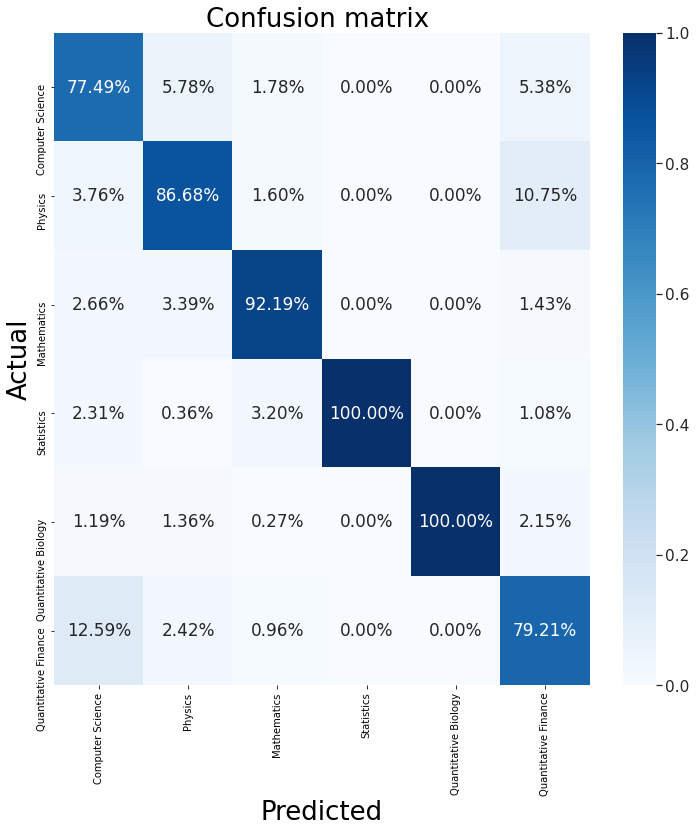

In [56]:
c_matrix=confusion_matrix(y_train_new,clf.predict(xtrain_tfv))

c_matrix=pd.DataFrame(c_matrix,columns=['Computer Science',
 'Physics',
 'Mathematics',
 'Statistics',
 'Quantitative Biology',
 'Quantitative Finance'],index=['Computer Science',
 'Physics',
 'Mathematics',
 'Statistics',
 'Quantitative Biology',
 'Quantitative Finance'])

fig,ax=plt.subplots(figsize=(12,12))
sns.set(font_scale=1.4)
sns.heatmap(c_matrix/np.sum(c_matrix),fmt="0.2%",annot=True,cmap="Blues",ax=ax)
ax.set_title("Confusion matrix ",fontsize=26)
ax.set_xlabel("Predicted",fontsize=26)
ax.set_ylabel("Actual",fontsize=26)

Text(79.49999999999999, 0.5, 'Actual')

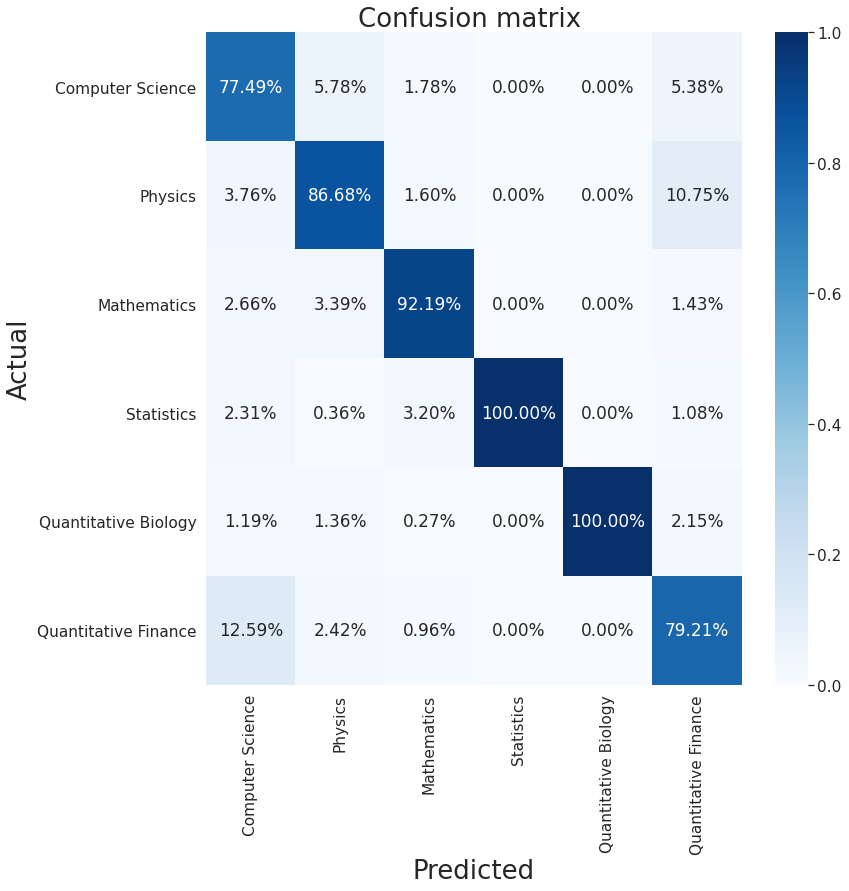

In [57]:
c_matrix2=confusion_matrix(y_test_new,clf.predict(xtest))

c_matrix2=pd.DataFrame(c_matrix,columns=['Computer Science',
 'Physics',
 'Mathematics',
 'Statistics',
 'Quantitative Biology',
 'Quantitative Finance'],index=['Computer Science',
 'Physics',
 'Mathematics',
 'Statistics',
 'Quantitative Biology',
 'Quantitative Finance'])

fig,ax=plt.subplots(figsize=(12,12))
sns.set(font_scale=1.4)
sns.heatmap(c_matrix/np.sum(c_matrix),fmt="0.2%",annot=True,cmap="Blues",ax=ax)
ax.set_title("Confusion matrix ",fontsize=26)
ax.set_xlabel("Predicted",fontsize=26)
ax.set_ylabel("Actual",fontsize=26)

We got 79.93 accuracy using logistic regression. and the macro average f1 score is 0.4557

# Changing words into vector using genism

In [58]:
# Tokenizing each sentense of cleaned_test
cleaned_tokens=[]
for sentance in cleaned_text:
    s=sentance.split()
    cleaned_tokens.append(s)
    
cleaned_tokens[2:3]

[['spherical',
  'polyharmonic',
  'poisson',
  'kernel',
  'polyharmonic',
  'function',
  'introduce',
  'develop',
  'notion',
  'spherical',
  'polyharmonic',
  'natural',
  'generalisation',
  'spherical',
  'harmonic',
  'particular',
  'study',
  'theory',
  'zonal',
  'polyharmonic',
  'allow',
  'analogously',
  'zonal',
  'harmonic',
  'construct',
  'poisson',
  'kernel',
  'polyharmonic',
  'function',
  'union',
  'rotated',
  'ball',
  'find',
  'representation',
  'poisson',
  'kernel',
  'zonal',
  'polyharmonic',
  'term',
  'gegenbauer',
  'polynomial',
  'connection',
  'classical',
  'poisson',
  'kernel',
  'harmonic',
  'function',
  'ball',
  'poisson',
  'kernel',
  'polyharmonic',
  'function',
  'union',
  'rotated',
  'ball',
  'cauchy',
  'hua',
  'kernel',
  'holomorphic',
  'function',
  'lie',
  'ball']]

In [59]:
# Clean data using the built in cleaner in gensim
import gensim
train_df['text_clean'] = train_df['text'].apply(lambda x: gensim.utils.simple_preprocess(x))
train_df.head()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,text,cleaned_text,text_clean
0,1,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps ...,reconstruct subject specific effect map predi...,"[reconstructing, subject, specific, effect, ma..."
1,2,1,0,0,0,0,0,Rotation Invariance Neural Network Rotation ...,rotation invariance neural network rotation i...,"[rotation, invariance, neural, network, rotati..."
2,3,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...,spherical polyharmonic poisson kernel polyharm...,"[spherical, polyharmonics, and, poisson, kerne..."
3,4,0,0,1,0,0,0,A finite element approximation for the stochas...,finite element approximation stochastic maxwel...,"[finite, element, approximation, for, the, sto..."
4,5,1,0,0,1,0,0,Comparative study of Discrete Wavelet Transfor...,comparative study discrete wavelet transforms ...,"[comparative, study, of, discrete, wavelet, tr..."


In [60]:
train_df['tokenized_text']=cleaned_tokens
train_df.head()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,text,cleaned_text,text_clean,tokenized_text
0,1,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps ...,reconstruct subject specific effect map predi...,"[reconstructing, subject, specific, effect, ma...","[reconstruct, subject, specific, effect, map, ..."
1,2,1,0,0,0,0,0,Rotation Invariance Neural Network Rotation ...,rotation invariance neural network rotation i...,"[rotation, invariance, neural, network, rotati...","[rotation, invariance, neural, network, rotati..."
2,3,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...,spherical polyharmonic poisson kernel polyharm...,"[spherical, polyharmonics, and, poisson, kerne...","[spherical, polyharmonic, poisson, kernel, pol..."
3,4,0,0,1,0,0,0,A finite element approximation for the stochas...,finite element approximation stochastic maxwel...,"[finite, element, approximation, for, the, sto...","[finite, element, approximation, stochastic, m..."
4,5,1,0,0,1,0,0,Comparative study of Discrete Wavelet Transfor...,comparative study discrete wavelet transforms ...,"[comparative, study, of, discrete, wavelet, tr...","[comparative, study, discrete, wavelet, transf..."


In [61]:
y_train=train_df.loc[:,categories].idxmax(axis=1)
y_train=y_train.replace(['Computer Science',
 'Physics',
 'Mathematics',
 'Statistics',
 'Quantitative Biology',
 'Quantitative Finance'],[0,1,2,3,4,5])
y_train=list(y_train.values)
y_train[:5]

[0, 0, 2, 2, 0]

In [62]:
train_df['target']=y_train
train_df.head()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,text,cleaned_text,text_clean,tokenized_text,target
0,1,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps ...,reconstruct subject specific effect map predi...,"[reconstructing, subject, specific, effect, ma...","[reconstruct, subject, specific, effect, map, ...",0
1,2,1,0,0,0,0,0,Rotation Invariance Neural Network Rotation ...,rotation invariance neural network rotation i...,"[rotation, invariance, neural, network, rotati...","[rotation, invariance, neural, network, rotati...",0
2,3,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...,spherical polyharmonic poisson kernel polyharm...,"[spherical, polyharmonics, and, poisson, kerne...","[spherical, polyharmonic, poisson, kernel, pol...",2
3,4,0,0,1,0,0,0,A finite element approximation for the stochas...,finite element approximation stochastic maxwel...,"[finite, element, approximation, for, the, sto...","[finite, element, approximation, stochastic, m...",2
4,5,1,0,0,1,0,0,Comparative study of Discrete Wavelet Transfor...,comparative study discrete wavelet transforms ...,"[comparative, study, of, discrete, wavelet, tr...","[comparative, study, discrete, wavelet, transf...",0


In [63]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split (train_df['tokenized_text'],
                                                     train_df['target'] , test_size=0.2)

In [64]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((16777,), (4195,), (16777,), (4195,))

In [65]:
#! pip install --upgrade gensim

In [66]:
#! pip install gensim

In [67]:
import gensim
print(gensim.__version__)

3.8.3


[gensim3 to gensim4](https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4)

In [68]:
import gensim
# Train the word2vec model
w2v_model = gensim.models.Word2Vec(X_train,
                                   window=5,
                                   size=100,
                                   min_count=2)

In [69]:
# from gensim.models import KeyedVectors
# filename = '../input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin'
# w2v_model = KeyedVectors.load_word2vec_format(filename, binary=True)

In [70]:
# Find the most similar words to "computer" based on word vectors from our trained model
w2v_model.wv.most_similar('computer')

[('vision', 0.9037588834762573),
 ('engineering', 0.8722891211509705),
 ('modern', 0.8693317770957947),
 ('science', 0.82513827085495),
 ('aid', 0.8248810172080994),
 ('ai', 0.8188698291778564),
 ('advanced', 0.8175793886184692),
 ('robotic', 0.8123648762702942),
 ('industrial', 0.8122684359550476),
 ('cav', 0.8113261461257935)]

In [71]:
words = set(w2v_model.wv.index2word )
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train])
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test])

In [72]:
max_sentense_length=0
cur=0
for i, v in enumerate(X_train_vect):
    current=len(X_train.iloc[i])
    if current>max_sentense_length:
        max_sentense_length=current
max_sentense_length

239

In [73]:
# Why is the length of the sentence different than the length of the sentence vector?
for i, v in enumerate(X_train_vect):
    if i>10:          # just looking at only 10 elements
        break     
    print(len(X_train.iloc[i]), len(v))

72 72
81 80
129 129
68 68
30 29
96 96
144 140
16 16
141 141
74 74
132 131


In [74]:
# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(438, dtype=float)) # 290 because maximum array len is 287
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(438, dtype=float))

In [75]:
# Are our sentence vector lengths consistent?
for i, v in enumerate(X_train_vect_avg):
    if i>10:
        break
    print(len(X_train.iloc[i]), len(v))

72 100
81 100
129 100
68 100
30 100
96 100
144 100
16 100
141 100
74 100
132 100


In [76]:
# Instantiate and fit a basic Random Forest model on top of the vectors
from sklearn.linear_model import LogisticRegression
#rf=LogisticRegression(C=1.0,solver="sag")

#rf_model = rf.fit(X_train_vect_avg, y_train.values.ravel())

In [77]:
# from sklearn.model_selection import GridSearchCV
# params={
#     'C':[0.1,0.5,1],
#     'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# }
# gs_knn = GridSearchCV(LogisticRegression(),
#                       param_grid=params,
#                       scoring='accuracy',
#                       cv=5)

# gs_model = gs_knn.fit(X_train_vect_avg, y_train.values.ravel())

In [78]:
# gs_model.best_params_

In [79]:
clf_model=LogisticRegression(C=1,solver="newton-cg")

clf_model.fit(X_train_vect_avg, y_train.values.ravel())

LogisticRegression(C=1, solver='newton-cg')

In [80]:
from sklearn.metrics import accuracy_score
print("train_accuracy",f1_score(y_train,clf_model.predict(X_train_vect_avg),average="macro"))
print("test_accuracy",f1_score(y_test,clf_model.predict(X_test_vect_avg),average='macro'))

train_accuracy 0.5920701697818362
test_accuracy 0.583747777318839


Text(79.49999999999999, 0.5, 'Actual')

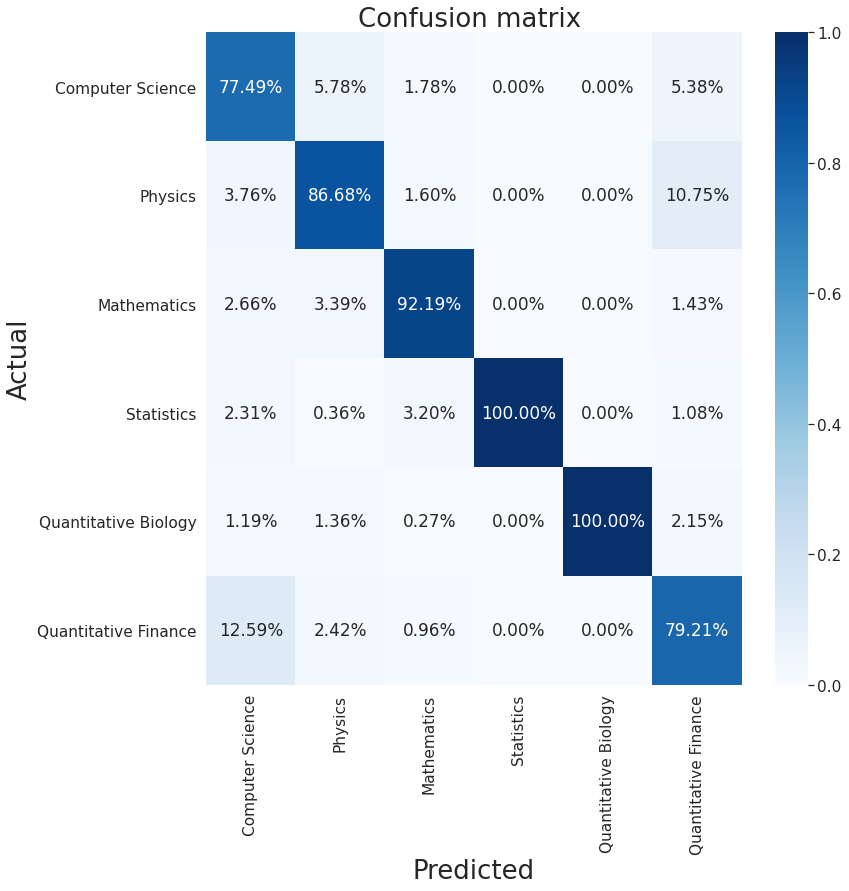

In [81]:
c_matrix3=confusion_matrix(y_train,clf_model.predict(X_train_vect_avg))
c_matrix3=pd.DataFrame(c_matrix,columns=['Computer Science',
 'Physics',
 'Mathematics',
 'Statistics',
 'Quantitative Biology',
 'Quantitative Finance'],index=['Computer Science',
 'Physics',
 'Mathematics',
 'Statistics',
 'Quantitative Biology',
 'Quantitative Finance'])

fig,ax=plt.subplots(figsize=(12,12))
sns.set(font_scale=1.4)
sns.heatmap(c_matrix/np.sum(c_matrix),fmt="0.2%",annot=True,cmap="Blues",ax=ax)
ax.set_title("Confusion matrix ",fontsize=26)
ax.set_xlabel("Predicted",fontsize=26)
ax.set_ylabel("Actual",fontsize=26)

In [82]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
import numpy as np
from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Embedding,Dense

In [83]:
# Cleaning 'text' column like removing stopwords , punctuations
# Using nltk library for this process
import nltk
import random
import re
import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

In [84]:
stopwords_eng=stopwords.words('english')
print('All Stopwords \n',stopwords_eng)
print('Punctuations \n',string.punctuation)

All Stopwords 
 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same',

In [85]:
cleaned_text[:2]

['reconstruct subject specific effect map  predictive model allow subject specific inference analyze disease relate alteration neuroimage datum give subject data inference level global identifiye condition presence subject local detect condition effect individual measurement extract subject datum global inference widely local inference form subject specific effect map rarely exist model yield noisy detection compose disperse isolate island article propose reconstruction method name rsm improve subject specific detection predictive modeling approach particular binary classifier rsm specifically aim reduce noise sampling error associate finite sample example train classifier propose method wrapper type algorithm different binary classifier diagnostic manner information condition presence reconstruction pose maximum posteriori problem prior model parameter estimate train datum classifier specific fashion experimental evaluation perform synthetically generate datum datum alzheimer disease 

In [86]:
len(cleaned_text)

20972

In [87]:
categories

['Computer Science',
 'Physics',
 'Mathematics',
 'Statistics',
 'Quantitative Biology',
 'Quantitative Finance']

In [88]:
y_train=train_df.loc[:,categories].idxmax(axis=1)
y_train=y_train.replace(['Computer Science',
 'Physics',
 'Mathematics',
 'Statistics',
 'Quantitative Biology',
 'Quantitative Finance'],[0,1,2,3,4,5])
y_train=y_train.values
y_train

array([0, 0, 2, ..., 0, 2, 2])

In [89]:
Vocab_size = 46000
encoded_text = [one_hot(d,Vocab_size) for d in cleaned_text]
print(f'encoded reviews: {encoded_text[:6]}')

encoded reviews: [[23581, 34592, 24047, 24332, 45265, 33036, 9786, 11530, 34592, 24047, 14538, 35541, 22751, 33279, 45553, 23304, 6837, 37404, 34592, 43389, 14538, 18335, 30615, 30226, 15310, 40376, 34592, 7376, 40617, 15310, 24332, 36004, 18680, 20512, 34592, 6837, 30615, 14538, 9628, 7376, 14538, 41955, 34592, 24047, 24332, 45265, 28915, 34990, 9786, 38701, 41333, 37590, 17702, 34294, 41473, 24521, 13982, 3599, 3735, 23243, 20460, 10146, 3752, 34592, 24047, 37590, 33036, 20909, 5336, 33428, 6674, 42591, 10146, 27610, 41668, 28486, 10846, 17315, 9323, 43054, 45259, 22442, 35058, 41187, 42591, 3599, 23243, 32918, 29018, 12307, 38648, 6674, 42591, 25540, 4834, 38083, 15310, 40376, 3735, 1769, 41422, 41688, 23621, 7806, 9786, 36597, 40662, 41187, 6837, 42591, 24047, 33750, 29549, 27709, 11529, 26984, 25086, 6837, 6837, 864, 22751, 39643, 15934, 3032, 10111, 6397, 36415, 6837, 25459, 10146, 38701, 42814, 37590, 24256, 9742, 9786, 19988, 37921, 22186, 21208, 3032, 28031, 10146, 3752, 30796

In [90]:
m=0
for i in encoded_text:
    m=max(m,len(i))
    
print(m)

239


In [91]:
max_length=239
padded_text = pad_sequences(encoded_text,maxlen=max_length,padding='pre')
print(padded_text)

[[    0     0     0 ... 37590 28109 10146]
 [    0     0     0 ... 10494  2211 41376]
 [    0     0     0 ...  5065 23647 43771]
 ...
 [    0     0     0 ...  1410 12789 27601]
 [    0     0     0 ...  9742 34990 30936]
 [    0     0     0 ... 14520 15839  7806]]


In [92]:
# Split data into train and test sets
x_train_m, x_test, y_train_m, y_test = train_test_split (padded_text,
                                                     y_train , test_size=0.2,random_state=0)
print(y_train_m.shape,x_train_m.shape,y_test.shape,x_test.shape)

(16777,) (16777, 239) (4195,) (4195, 239)


In [93]:
# import tensorflow as tf
# import keras.backend as K

# def f1(y_true, y_pred):
#     y_pred = K.round(y_pred)
#     tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
#     # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
#     fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
#     fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

#     p = tp / (tp + fp + K.epsilon())
#     r = tp / (tp + fn + K.epsilon())

#     f1 = 2*p*r / (p+r+K.epsilon())
#     f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
#     return K.mean(f1)

In [94]:
# def fbeta_score_macro(y_true, y_pred, beta=1, threshold=0.5):

#     y_true = K.cast(y_true, 'float')
#     y_pred = K.cast(K.greater(K.cast(y_pred, 'float'), threshold), 'float')

#     tp = K.sum(y_true * y_pred, axis=0)
#     fp = K.sum((1 - y_true) * y_pred, axis=0)
#     fn = K.sum(y_true * (1 - y_pred), axis=0)

#     p = tp / (tp + fp + K.epsilon())
#     r = tp / (tp + fn + K.epsilon())

#     f1 = (1 + beta ** 2) * p * r / ((beta ** 2) * p + r + K.epsilon())
#     f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

#     return K.mean(f1)

In [95]:
# f1=tfa.metrics.F1Score(
#     num_classes=6,
#     average='macro',
#     threshold=0.5
# )

In [96]:
# from tensorflow.keras.layers import Dense,LSTM 
# from tensorflow.keras.layers import Dropout
# import tensorflow_addons as tfa
# model = Sequential()
# embedding_layer = Embedding(input_dim=Vocab_size,output_dim=40,input_length=max_length)
# model.add(embedding_layer)

# model.add(LSTM(100,
#                input_shape=x_train_m.shape,
#                return_sequences=True))
# model.add(Flatten())
# model.add(Dropout(0.2))
# model.add(Dense(6,activation="softmax"))
# model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=[f1])
# model.summary()

In [97]:
# final_docs=model.predict(padded_text)
# final_docs[:3]

In [98]:
# model.fit(x_train_m,y_train_m,validation_data=(x_test,y_test),epochs=10,verbose=1)

In [99]:
# pred=model.predict(x_train_m)
# pred


# References

* https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/

* https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff